In [21]:
!apt-get update -y 
!apt-get install libgl1-mesa-glx -y 
!pip install opencv-python
!pip install matplotlib

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]    
Fetched 252 kB in 0s (523 kB/s)                              
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgl1-mesa-glx is already the newest version (20.0.8-0ubuntu1~18.04.1).
0 upgraded, 0 newly installed, 0 to remove and 61 not upgraded.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


    0. Imports, define constants

In [1]:
#%matplotlib qt
import matplotlib
%matplotlib --list
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
TEST_IMAGE_DIR = "./test_images"
OUT_PUT = "./output_images"

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'wx', 'qt4', 'qt5', 'qt', 'osx', 'nbagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


     1. Calibrate the camera (code taken from example.py)

In [2]:
class CameraCalibrator():
    def __init__(self):
        self.objp = np.zeros((6*9,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        self.calibration_images = glob.glob('./camera_cal/calibration*.jpg')
    def calibrate(self, draw=False):
        for fname in self.calibration_images:
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
            print(ret)
            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)

                if draw == True :
                    # Draw and display the corners
                    img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                    plt.imshow(img)
                    plt.show()

            ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, 
                                                               gray.shape[::-1],None,None)

    def undistort_framme(self,framme):
        undistorted = cv2.undistort(framme, 
                                    self.mtx, self.dist)
        return undistorted

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    calibration_images = [] 
    mtx = None
    dist = None
    rvecs = None
    tvecs = None
    objp = None

In [3]:
calibrator = CameraCalibrator()
calibrator.calibrate()
test_images = glob.glob('./test_images/*.jpg')
hard_images = glob.glob('./hard_images/*.jpeg')
callibreted_frammes = {}
hard_callibreted_frammes = {}
for frame in test_images: 
    test_img = cv2.imread(frame)
    callibreted_frammes[frame] = (calibrator.undistort_framme(test_img))

def show_images_dif(original_image , new_image):
    plt.imshow(original_image, cmap='gray')
    plt.imshow(new_image, cmap='jet', alpha=0.5) 
    plt.show()
    return 

True
True
False
True
True
True
True
True
True
False
True
True
True
True
False
True
True
True
True
True
['./test_images/test4.jpg', './test_images/straight_lines2.jpg', './test_images/test1.jpg', './test_images/test6.jpg', './test_images/test5.jpg', './test_images/straight_lines1.jpg', './test_images/test3.jpg', './test_images/test2.jpg']
['./hard_images/image-002.jpeg', './hard_images/image-014.jpeg', './hard_images/image-011.jpeg', './hard_images/image-018.jpeg', './hard_images/image-017.jpeg', './hard_images/image-010.jpeg', './hard_images/image-003.jpeg', './hard_images/image-004.jpeg', './hard_images/image-009.jpeg', './hard_images/image-001.jpeg', './hard_images/image-012.jpeg', './hard_images/image-016.jpeg', './hard_images/image-007.jpeg', './hard_images/image-015.jpeg', './hard_images/image-008.jpeg', './hard_images/image-006.jpeg', './hard_images/image-005.jpeg', './hard_images/image-013.jpeg']


In [4]:
for frame in hard_images: 
    test_img = cv2.imread(frame)
    callibreted_frammes[frame] = (calibrator.undistort_framme(test_img))

Result after colibration :

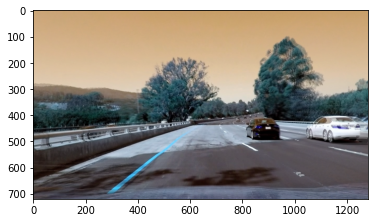

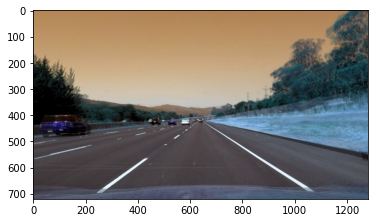

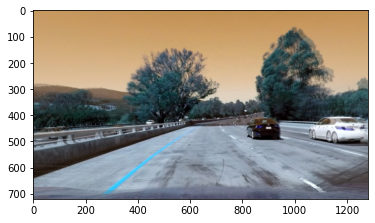

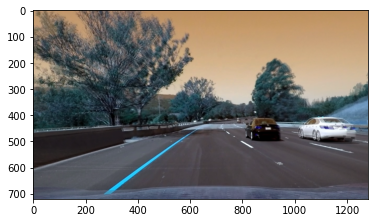

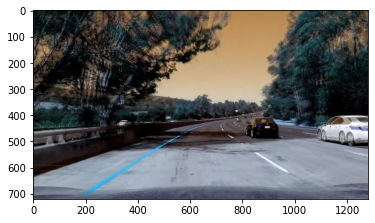

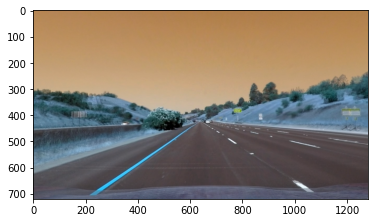

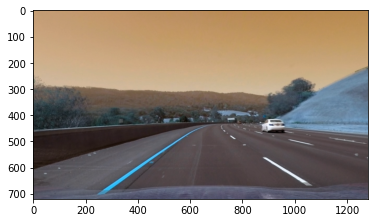

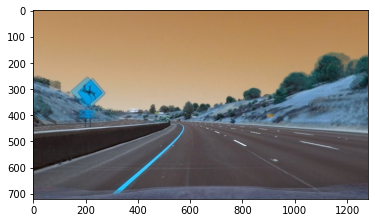

In [159]:
for frame in test_images: 
    img = cv2.imread(frame)
    show_images_dif(img , callibreted_frammes[frame])

    2. Perspective transformer

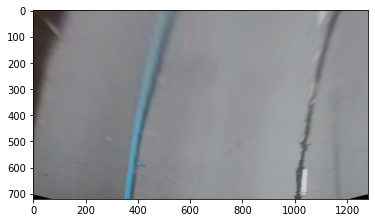

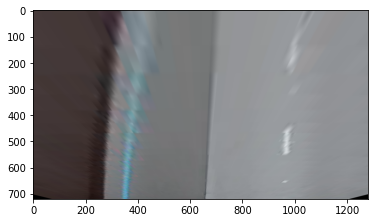

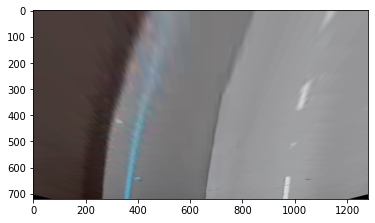

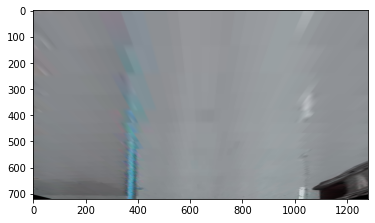

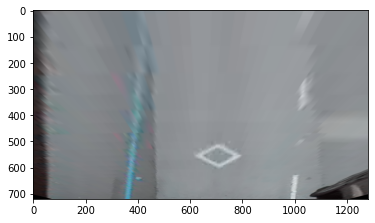

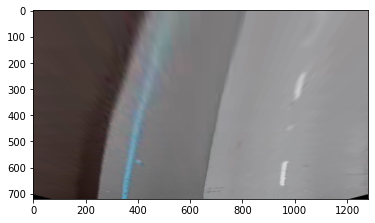

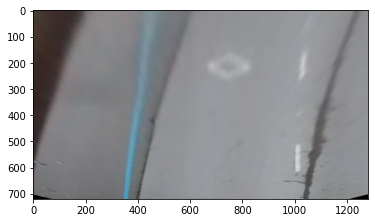

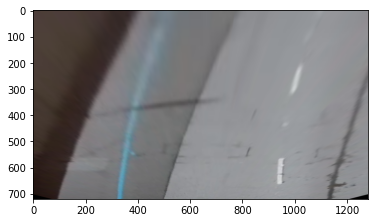

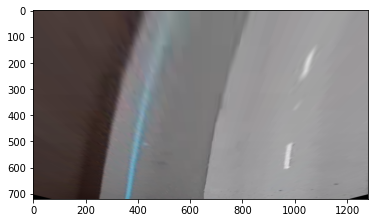

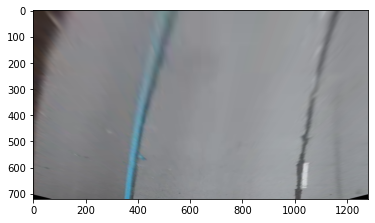

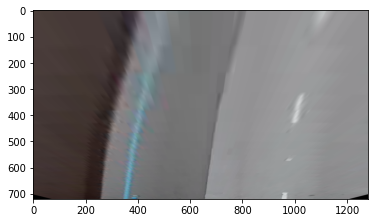

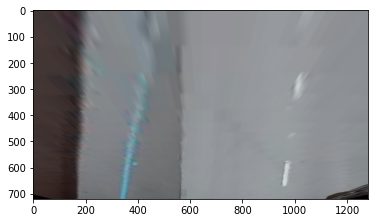

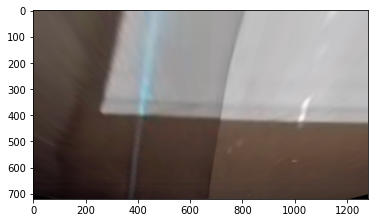

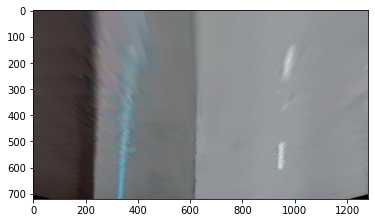

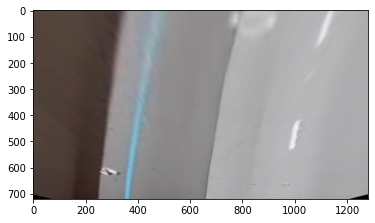

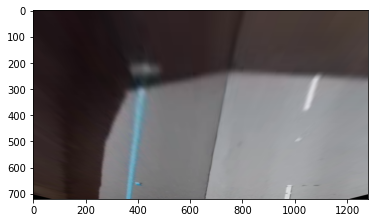

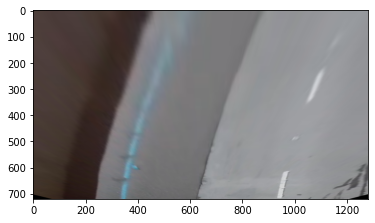

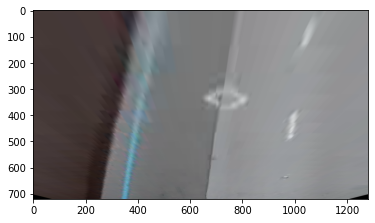

In [208]:
#      col(x) row(y)
p1  = [ 210 , 680 ]  #  p2  ____ p3
p2  = [ 570 , 460 ]  #     /    \
p3  = [ 710 , 460 ]  #    /     \
p4  = [ 1070, 680 ]  #p1 /______\ p4
simple_camera_roi = np.array([p1,p2,p3,p4] , np.int32)

p1_hard  = [ 210 , 690 ]  #  p2  ____ p3
p2_hard  = [ 578 , 480 ]  #     /    \
p3_hard  = [ 717 , 480 ]  #    /     \
p4_hard  = [ 1070, 690 ]  #p1 /______\ p4


hard_camera_roi = np.array([p1_hard,p2_hard,p3_hard,p4_hard] , np.int32)

p1_transofrmed = [ 260 , 720  ]        #  p2  ____ p3
p2_transofrmed = [ 260 , 0    ]        #     /    \
p3_transofrmed = [ 1020 , 0   ]        #    /     \
p4_transofrmed = [ 1020 , 720 ]        #p1 /______\ p4

transformed_roi = np.float32([p1_transofrmed,p2_transofrmed,p3_transofrmed,p4_transofrmed])


class perspectiveTransformer():
    def __init__(self, roi ,camera_roi ):
        self.camera_roi = camera_roi
        self.roi = roi
        self.M = cv2.getPerspectiveTransform(camera_roi, roi)
        self.invM = cv2.getPerspectiveTransform(roi, camera_roi)
        
    def to_bird_view(self, frame):
        return cv2.warpPerspective(frame, self.M, 
                           (frame.shape[1], frame.shape[0]),
                           flags=cv2.INTER_LINEAR)
    
    def to_normal_view(self, frame):
        return cv2.warpPerspective(frame, self.invM, 
                                   (frame.shape[1], frame.shape[0]),
                                   flags=cv2.INTER_LINEAR)
    
    M = None
    invM = None
    camera_roi = []
    roi = []
bird = perspectiveTransformer(transformed_roi, hard_camera_roi.astype(np.float32))
transformed_images = {}

for frame in hard_images:
    transformed_images[frame] = bird.to_bird_view(callibreted_frammes[frame])
    plt.imshow(transformed_images[frame]) 
    plt.show()

Test transformation

    3. Use color transforms, gradients, etc., to create a thresholded binary image.

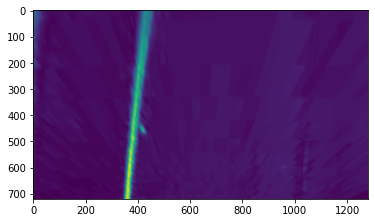

In [8]:
test = cv2.cvtColor(transformed_images[hard_images[0]] , cv2.COLOR_RGB2HLS)[:,:,2]
plt.imshow(test) 
plt.show()

./test_images/test4.jpg


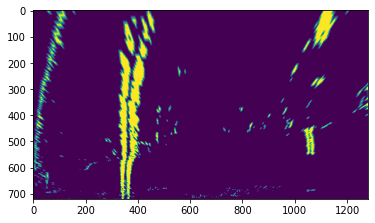

./test_images/straight_lines2.jpg


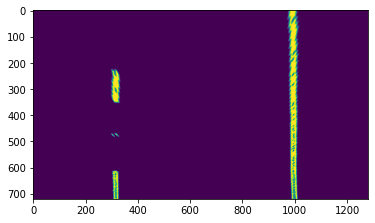

./test_images/test1.jpg


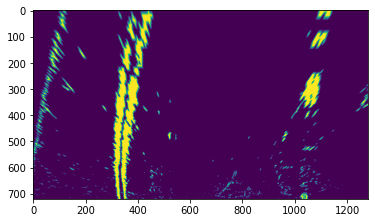

./test_images/test6.jpg


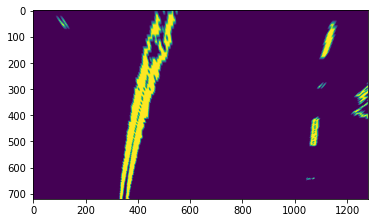

./test_images/test5.jpg


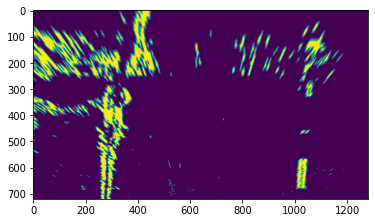

./test_images/straight_lines1.jpg


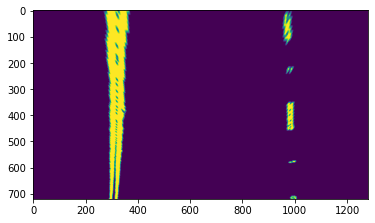

./test_images/test3.jpg


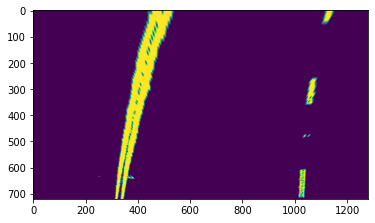

./test_images/test2.jpg


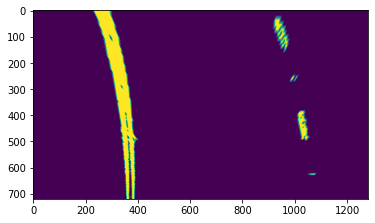

In [167]:
ksize = 15 # Choose a larger odd number to smooth gradient measurements

class BinaryTransformer():
    mag_thresh = (30,100)
    thresh = (10, 180)
    direction_thresh=(0.8, 1.1)
    suturation_thresh = (50,255)
    value_thresh = (171,255)
    rgb_tresh = (200,200,200)
    ksize = 7

    def __init__(self):
        return 
    def color_filter(self,frame):
        hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
        hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
        H = hls[:,:,0]
        L = hls[:,:,1]
        S = hls[:,:,2]
        
        V = hsv[:,:,2]
        
        R = frame[:,:,0]
        G = frame[:,:,1]
        B = frame[:,:,2]
        
        binary = np.zeros_like(S)
        binary[((S > self.suturation_thresh[0]) & (S <= self.suturation_thresh[1])) |
               ((V > self.value_thresh[0]) & (V <= self.value_thresh[1]))
               | (R > self.rgb_tresh[0]) & (G > self.rgb_tresh[1]) & (B > self.rgb_tresh[2])] = 1
        return binary
    
    def mag_thresh(self,image, sobel_kernel=3, mag_thresh=(0, 255)):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        saturation = cv2.cvtColor(image , cv2.COLOR_RGB2HLS)[:,:,2]
        sobelx = cv2.Sobel(saturation, cv2.CV_64F, 1, 0,ksize =  sobel_kernel)
        sobely = cv2.Sobel(saturation, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        
        sobelx =sobelx + cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize =  sobel_kernel)
        sobely =sobely + cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        sobely_total = np.sqrt(sobelx**2 + sobely**2)

        scaled_sobel = np.uint8(255*sobely_total/np.max(sobely_total))
        binary_output = np.zeros_like(scaled_sobel)
        binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        return binary_output
    
    def abs_sobel_thresh(self,img, orient='x', sobel_kernel=3 ):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        saturation = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
        if orient == 'x':
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
            sobelx =sobelx + cv2.Sobel(saturation, cv2.CV_64F, 1, 0)
        else:
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 0,1)
            sobelx =sobelx + cv2.Sobel(saturation, cv2.CV_64F, 0,1)
        abs_sobelx = np.absolute(sobelx)
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= self.thresh[0]) & (scaled_sobel <= self.thresh[1])] = 1
        return sxbinary

    def dir_threshold(self,image, sobel_kernel=3, thresh=(0, np.pi/2)):
        saturation = cv2.cvtColor(image , cv2.COLOR_RGB2HLS)[:,:,2]
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize =  sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
        
        sobelx =sobelx +  cv2.Sobel(saturation, cv2.CV_64F, 1, 0,ksize =  sobel_kernel)
        sobely =sobely +  cv2.Sobel(saturation, cv2.CV_64F, 0, 1,ksize = sobel_kernel)

        directional =  np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        binary_output = np.zeros_like(directional) # Remove this line

        binary_output[(directional > self.direction_thresh[0]) & (directional < self.direction_thresh[1])] = 1
        return binary_output


    def binary_transform(self,frame):
        # Apply each of the thresholding functions
        saturation = cv2.cvtColor(frame , cv2.COLOR_RGB2HLS)[:,:,2]
        gradx = self.abs_sobel_thresh(frame, orient='x', sobel_kernel=self.ksize)
        grady = self.abs_sobel_thresh(frame, orient='y',
                                 sobel_kernel=self.ksize)

        mag_binary = self.mag_thresh(frame, sobel_kernel=self.ksize,
                                mag_thresh=(20, 120))
        dir_binary = self.dir_threshold(frame, sobel_kernel=self.ksize)
        color_binary = self.color_filter(frame)
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1)
                 | ((mag_binary == 1)
                    & (dir_binary == 1))) & (color_binary==1)] = 1
        return combined

    
binaryTransformer = BinaryTransformer()
binary_images = {}
for frame in test_images:
    binary_images[frame] = binaryTransformer.binary_transform(
        callibreted_frammes[frame])
bird = perspectiveTransformer(transformed_roi, simple_camera_roi.astype(np.float32))
binary_wrapped = {}

for frame in test_images:
    print(frame)
    binary_wrapped[frame] = bird.to_bird_view(binary_images[frame])
    plt.imshow(binary_wrapped[frame]) 
    plt.show()




    4. Apply a perspective transform to rectify binary image ("birds-eye view").

    5. Detect lane pixels and fit to find the lane boundary.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


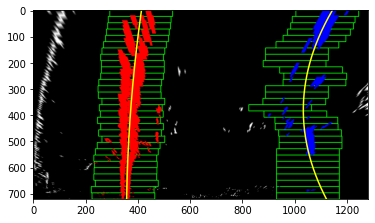

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


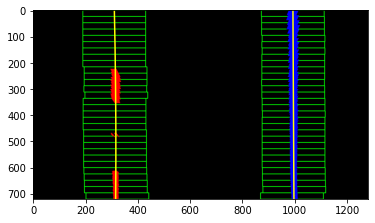

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


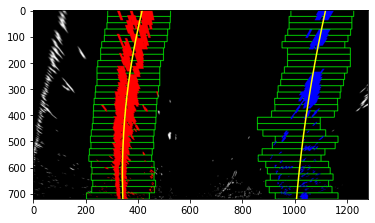

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


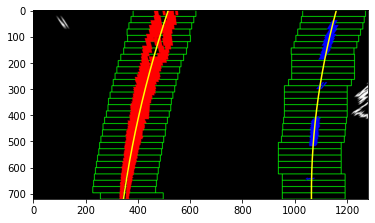

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


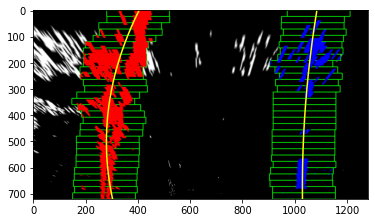

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


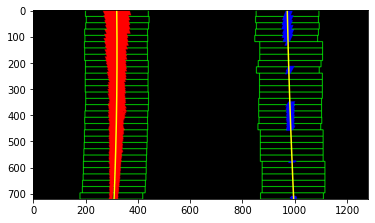

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


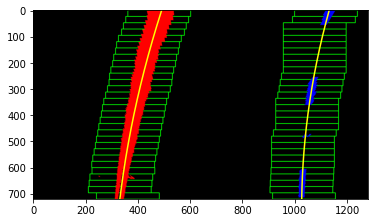

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


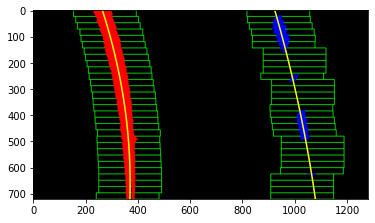

In [168]:
# Load our image
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 30
    # Set the width of the windows +/- margin
    margin = 120
    # Set minimum number of pixels found to recenter window
    minpix = 60

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
 # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

lane_boundary = {}

for frame in test_images:
    lane_boundary[frame] = fit_polynomial(binary_wrapped[frame])
    plt.imshow(lane_boundary[frame]) 
    plt.show()
# for frame in test_images:
#     print(frame)
#     lane_boundary[frame] = fit_polynomial(binary_wrapped[frame])
#     plt.imshow(lane_boundary[frame]) 
#     plt.show()


    6. Determine the curvature of the lane and vehicle position with respect to center.
        7. Determine the curvature of the lane and vehicle position with respect to center.

In [11]:
# calibrator = CameraCalibrator() 
# calibrator.calibrate()

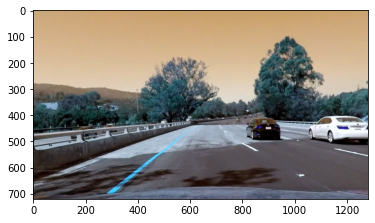

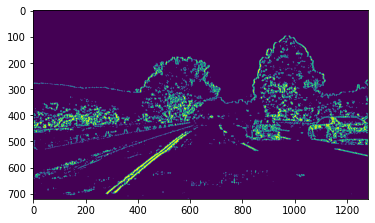

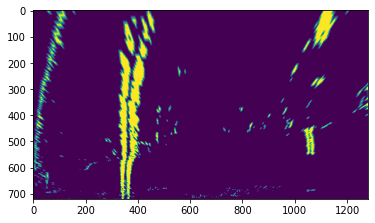

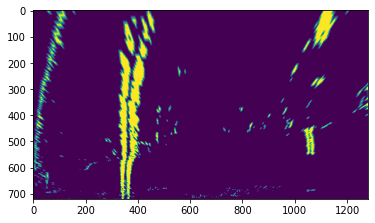

error: OpenCV(4.4.0) /tmp/pip-req-build-qacpj5ci/opencv/modules/core/src/arithm.cpp:666: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [239]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
lane_boundary = {}
def rotate(l, n):
    return l[n:] + l[:n]
def rightRotate(lists, num): 
    output_list = [] 
      
    # Will add values from n to the new list 
    for item in range(len(lists) - num, len(lists)): 
        output_list.append(lists[item]) 
      
    # Will add the values before 
    # n to the end of new list     
    for item in range(0, len(lists) - num):  
        output_list.append(lists[item]) 
          
    return output_list 
class Determiner:
    left_fit = np.array([ 0, 0,  0])
    right_fit = np.array([ 0, 0,  0])
    test_lst = [0]
    isfirst = False
    
    leftx = []
    lefty = []
    rightx = []
    righty = []
    
    memory_buffer = []
    memory_buffer_size = 0
    video_mode = False
        
    debug = True
    ym_per_pix = 27/720.0 # meters per pixel in y dimension
    xm_per_pix = 3.7/710.0 # meters per pixel in x dimension
    birdTransformer   = None
    binaryTransformer = None
    memory_buffer_size= 0
    video_mode        = False
    is_first_frame = True
    right_sample_qulity = False
    left_sample_qulity = False
    leftx_base = 0
    rightx_base = 0
    delta = 0
    simple_filter = False
    def __init__(self,video_mode = False, camera_roi = simple_camera_roi, window_size = 0):
        
        self.birdTransformer = perspectiveTransformer(transformed_roi, camera_roi.astype(np.float32)) # for 4
        self.binaryTransformer = BinaryTransformer()
        self.memory_buffer_size = window_size
        
        return 
    def process_frame(self, frame):
        
        undisorted = calibrator.undistort_framme(frame)
        if self.debug :
            plt.imshow(undisorted) 
            plt.show()
        binary_image = self.binaryTransformer.binary_transform(undisorted)
        if self.debug :
            plt.imshow(binary_image) 
            plt.show()
            
        tranformed_binary = self.birdTransformer.to_bird_view(binary_image)
            

        consensus_res = np.zeros_like(tranformed_binary)
        if self.video_mode == True :
            if self.right_sample_qulity == True or self.left_sample_qulity == True or self.simple_filter ==True: 
                consensus = np.zeros_like(tranformed_binary)
                if self.memory_buffer_size > len(self.memory_buffer) :
                    self.memory_buffer.append(tranformed_binary)
                    self.test_lst.append(self.test_lst[len(self.test_lst)-1]+1)
                else :
                    self.memory_buffer[ len(self.memory_buffer) - 1 ] = tranformed_binary
                    self.test_lst[len(self.test_lst)-1] = self.test_lst[0] + 1
                self.memory_buffer = rotate(self.memory_buffer,1)

                for i in range (0, len(self.memory_buffer)):
                    consensus = consensus + self.memory_buffer[i] 

                consensus_res = np.zeros_like(tranformed_binary)
                consensus_res[ consensus > 0 ] = 1
            
#         plt.imshow(tranformed_binary+consensus_res) 
#         plt.show()
        if self.debug :
            plt.imshow(tranformed_binary+consensus_res) 
            plt.show()
        if self.debug :
            plt.imshow(tranformed_binary) 
            plt.show()
        res = self.search_around_poly(tranformed_binary+consensus_res, undisorted)
        if self.debug :
            plt.imshow(res) 
            plt.show()
        return res
        
    def reset (self,video_mode = False, camera_roi = simple_camera_roi, window_size = 0, simple_filter = False):
        # reset of calibrator is not so needed
        self.left_fit = np.array([ 0, 0,  0])
        self.right_fit = np.array([ 0, 0,  0])
        self.is_first_frame = True

        self.birdTransformer    = perspectiveTransformer(transformed_roi, camera_roi.astype(np.float32)) # for 4
        self.binaryTransformer  = BinaryTransformer()
        self.memory_buffer_size = window_size
        self.video_mode         = video_mode
        self.simple_filter = simple_filter
        
    def fit_first_polynomial(self,binary_warped):
        # Find our lane pixels first
        self.leftx, self.lefty, self.rightx, self.righty, out_img = find_lane_pixels(binary_warped)

        ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
        self.left_fit = np.polyfit(self.lefty, self.leftx, 2)
        self.right_fit = np.polyfit(self.righty, self.rightx, 2)
        


    def fit_poly(self,img_shape):
        self.left_fit = np.polyfit(self.lefty ,self.leftx, 2)
        self.right_fit = np.polyfit(self.righty ,self.rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###

        left_fitx = self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        right_fitx = self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        return left_fitx, right_fitx, ploty

    def search_around_poly(self,binary_warped , original):
        margin = 40

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        

        if self.is_first_frame == True :
            self.fit_first_polynomial(binary_warped)
            self.is_first_frame = False


        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + 
                        self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + 
                        self.left_fit[1]*nonzeroy + self.left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + 
                        self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + 
                        self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))

        # Again, extract left and right line pixel positions
        self.leftx = nonzerox[left_lane_inds]
        self.lefty = nonzeroy[left_lane_inds] 
        self.rightx = nonzerox[right_lane_inds]
        self.righty = nonzeroy[right_lane_inds]

        
        # Fit new polynomials
        if self.leftx.size == 0 :
            self.leftx = self.rightx - self.delta
            self.lefty = self.righty
            
        if self.rightx.size == 0:
            self.rightx = self.leftx + 650
            self.righty = self.lefty
            


        if np.any(self.righty[:] > 600) :
            if (np.any(self.righty[:] < 600) and np.any(self.righty[:] > 300)) :
                if np.any(self.righty[:] < 150):
                    self.right_sample_qulity = True 
        
        if np.any(self.lefty[:] > 600) :
            if (np.any(self.lefty[:] < 600) and np.any(self.righty[:] > 300)) :
                if np.any(self.lefty[:] < 100):
                    self.left_sample_qulity = True 
                    
        if self.left_sample_qulity == False and self.right_sample_qulity ==True :
            self.leftx = self.rightx - self.delta
            self.lefty = self.righty
            
        if self.left_sample_qulity == True and self.right_sample_qulity ==False :
            self.rightx = self.leftx + self.delta
            self.righty = self.lefty

        left_fitx, right_fitx, ploty = self.fit_poly(binary_warped.shape)

        # aproximatly start of lane 
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        left_hist = histogram[int(self.left_fit[2] - margin):int(self.left_fit[2] + margin)]
        if left_hist.size != 0:
            left = np.argmax(left_hist)
            if left > 0 :
                self.leftx_base = left
                
        right_hist = histogram[int(self.right_fit[2] - margin):int(self.right_fit[2] + margin)]
        if right_hist.size != 0:
            right = np.argmax(right_hist) + midpoint
            if right > 0 :
                self.rightx_base = right
        
        self.delta = self.rightx_base - self.leftx_base
            #print(right)
            
        

        ## Visualization ##
        out_img = np.zeros((720,1280,3), dtype='uint8')
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        draw_points_l = (np.asarray([left_fitx, ploty]).T).astype(np.int32)
        draw_points_r = (np.asarray([right_fitx, ploty]).T).astype(np.int32)
        curv, offset = self.measure_curvature_real()
        color = (0,127,0)
        if  ( self.right_sample_qulity == False and self.left_sample_qulity == False ) and self.simple_filter == False: 
            color =  (127,0,0) 
        else:
            color = (0,127,0)
            
            
        message1 = "Radius of Curvature :" + str(round(curv,2))
        message2 = "Vechicle offset :" + str( round(offset,2))
        
        cv2.fillPoly( window_img, [ np.concatenate( (draw_points_l, np.flip(draw_points_r,0) ) ) ], color ) 
        cv2.polylines(window_img, [draw_points_l], False, (255,200,0), thickness=25 )
        cv2.polylines(window_img, [draw_points_r], False, (0,200,255), thickness=25 )
        window_img_normal = self.birdTransformer.to_normal_view(window_img)
        result = cv2.addWeighted(original, 1, window_img_normal, 0.8, 0)

        
        cv2.putText(result, message1, (40,50), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3 )
        cv2.putText(result, message2, (40,100), cv2.FONT_HERSHEY_PLAIN, 3, (255,255,255), thickness=3 )

        return result #self.drawLine(out_img,original)
    
    def measure_curvature_real(self):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''
        # Define conversions in x and y from pixels space to meters


        # Start by generating our fake example data
        # Make sure to feed in your real data instead in your project!
        ploty = np.linspace(0, 719, 720)
        
        left_fit_cr =  np.polyfit(self.lefty * self.ym_per_pix, self.leftx * self.xm_per_pix, 2) 
        right_fit_cr = np.polyfit(self.righty* self.ym_per_pix, self.rightx* self.xm_per_pix, 2)
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        # Calculation of R_curve (radius of curvature)
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*self.ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*self.ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

        left_pos  = left_fit_cr[0]*y_eval*self.ym_per_pix*y_eval*self.ym_per_pix + left_fit_cr[1]*y_eval*self.ym_per_pix + left_fit_cr[2] - (640.0 * self.xm_per_pix )
        right_pos = right_fit_cr[0]*y_eval*self.ym_per_pix*y_eval*self.ym_per_pix + right_fit_cr[1]*y_eval*self.ym_per_pix + right_fit_cr[2] - (640.0 * self.xm_per_pix )
        
        curvature = (left_curverad + right_curverad)/2.0
        offset = left_pos+right_pos

        return curvature, offset

lane_processor = Determiner()
lane_processor.reset (video_mode = False, camera_roi = simple_camera_roi, window_size = 3)
for frame in test_images:
    
    #lane_boundary[frame] = lane_processor.search_around_poly(binary_wrapped[frame] , callibreted_frammes[frame] )
    #res = cv2.addWeighted(callibreted_frammes[frame], 1, lane_boundary[frame], 0.3, 0)
    lane_processor.process_frame(cv2.imread(frame))

In [82]:
!pip install moviepy
from moviepy.editor import VideoFileClip
from IPython.display import HTML

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


 Test on video 
 
 Lets remember what we need :
    1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    2. Apply a distortion correction to raw images.
    3. Use color transforms, gradients, etc., to create a thresholded binary image.
    4. Apply a perspective transform to rectify binary image ("birds-eye view").
    5. Detect lane pixels and fit to find the lane boundary.
    6. Determine the curvature of the lane and vehicle position with respect to center.
    7. Warp the detected lane boundaries back onto the original image.
    8. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [233]:
lane_processor.reset()
lane_processor.video_mode = True
lane_processor.memory_buffer_size = 3
white_output = './output_videos/01_project_video.mp4'
lane_processor.debug = False
lane_processor.reset (video_mode = True, camera_roi = simple_camera_roi, window_size = 2,simple_filter = True )
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(lane_processor.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


                                                          
t:   0%|          | 6/1260 [05:38<15:11,  1.38it/s, now=None]
                                                          
t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]ow=None]

Moviepy - Building video ./output_videos/01_project_video.mp4.
Moviepy - Writing video ./output_videos/01_project_video.mp4



                                                                
                                                          
t:   0%|          | 6/1260 [08:50<15:11,  1.38it/s, now=None]
                                                          
t:   0%|          | 6/1260 [08:50<15:11,  1.38it/s, now=None]

Moviepy - Done !
Moviepy - video ready ./output_videos/01_project_video.mp4
CPU times: user 18min 48s, sys: 10min 34s, total: 29min 22s
Wall time: 3min 11s


Chalange 1. 


In [234]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [228]:
lane_processor.reset()
lane_processor.video_mode = True
lane_processor.debug = False
white_output = './output_videos/02_project_video.mp4'
lane_processor.reset (video_mode = True, camera_roi = hard_camera_roi, window_size = 30,simple_filter = False)
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(lane_processor.process_frame) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   0%|          | 2/485 [00:00<00:30, 15.67it/s, now=None]

Moviepy - Building video ./output_videos/02_project_video.mp4.
Moviepy - Writing video ./output_videos/02_project_video.mp4




t:  26%|██▌       | 127/485 [00:17<00:52,  6.85it/s, now=None]


t:  52%|█████▏    | 251/485 [00:36<00:33,  6.98it/s, now=None]


t:  77%|███████▋  | 375/485 [00:54<00:16,  6.86it/s, now=None]


t:  12%|█▏        | 59/485 [23:16<01:04,  6.66it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_videos/02_project_video.mp4
CPU times: user 7min 19s, sys: 4min 9s, total: 11min 29s
Wall time: 1min 10s


In [229]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))